In [862]:
import numpy as np
import cv2 as cv
from plantcv import plantcv as pcv
import matplotlib.pyplot as plt
from collections import Counter
from scipy.spatial.distance import euclidean
import warnings
warnings.filterwarnings("ignore")

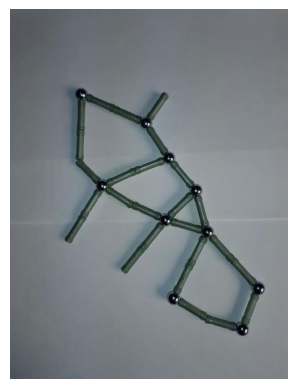

In [863]:
image = cv.imread('2.jpg')
plt.axis('off')
plt.imshow(image)

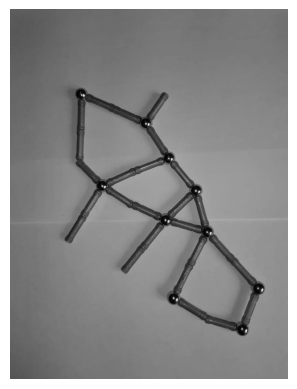

In [864]:
imgray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
plt.axis('off')
plt.imshow(imgray, cmap='gray')

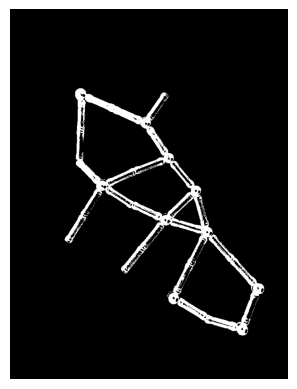

In [865]:
thresh = pcv.threshold.binary(gray_img=imgray, threshold=75, max_value=255, object_type='dark')
plt.axis('off')
plt.imshow(thresh, cmap='gray')

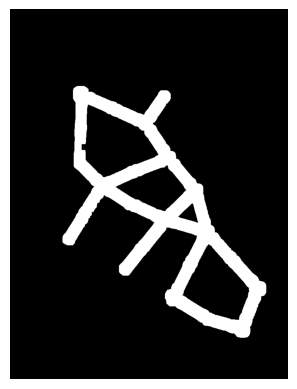

In [866]:
dil = cv.dilate(thresh, np.ones((13, 13), 'uint8'), iterations=1)
plt.axis('off')
plt.imshow(dil, cmap='gray')

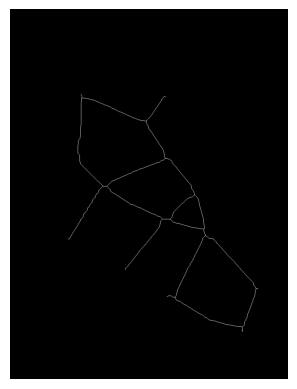

In [867]:
skeleton = pcv.morphology.skeletonize(mask=dil)
plt.axis('off')
plt.imshow(skeleton, cmap='gray')

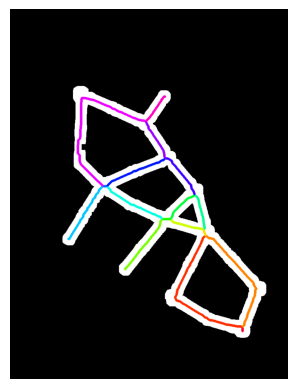

In [868]:
pruned_skeleton, segmented_img, segment_objects = pcv.morphology.prune(skel_img=skeleton, size=100, mask=dil)
plt.axis('off')
plt.imshow(segmented_img, cmap='gray')

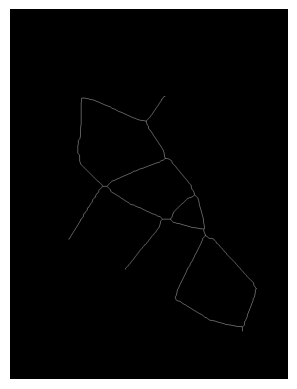

In [869]:
plt.axis('off')
plt.imshow(pruned_skeleton, cmap='gray')

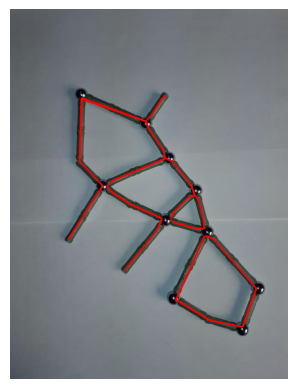

In [870]:
approxes = []
for segment in segment_objects:
    epsilon = 0.01 * cv.arcLength(segment, True)
    approx = cv.approxPolyDP(segment, epsilon, True)
    if cv.arcLength(approx, True) > (image.shape[0] + image.shape[1]) * 0.05:
        approxes.append(approx)

shape = image.copy()
cv.drawContours(shape, approxes, -1, (255, 0, 0), 3)
plt.axis('off')
plt.imshow(shape, cmap='gray')

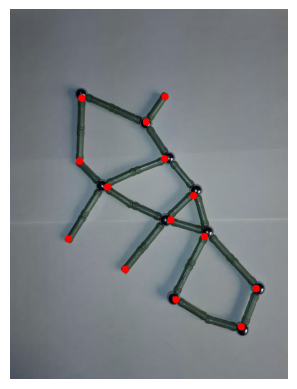

In [871]:
def append_node(node, nodes):
    flag = True
    if node[0] < 10 or node[1] < 10 or node[0] + 10 > image.shape[1] or node[1] + 10 > image.shape[0]:
        flag = False
    for i in nodes:
        if euclidean(i, node) < 50:
            flag = False
    if flag:
        nodes.append(node)
        return nodes
    return nodes

nodes = []
for line in approxes:
    max_node = np.argmax(line[:, 0, :], axis=0)
    min_node = np.argmin(line[:, 0, :], axis=0)
    nodes = append_node(line[max_node[0]][0], nodes)
    nodes = append_node(line[max_node[1]][0], nodes)
    nodes = append_node(line[min_node[0]][0], nodes)
    nodes = append_node(line[min_node[1]][0], nodes)
    for i in range(1, len(line)):
        k = (line[i][0][0] - line[i - 1][0][0]) / (line[i][0][1] - line[i - 1][0][1])
        if i != 1:
            if k * past_k < 0:
                nodes = append_node(line[i - 1][0], nodes)
        past_k = k

image_nodes = image.copy()        
for node in nodes:
    cv.circle(image_nodes, node, 10, (255, 0, 0), -1)
plt.axis('off')
plt.imshow(image_nodes)    

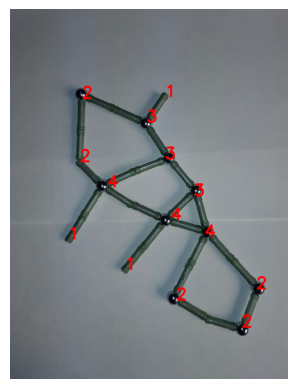

In [872]:
nodes_matrix = [[0] * len(nodes) for i in range(len(nodes))]
for index_line, line in enumerate(approxes):
    past_node = -1
    for index_point, point in enumerate(line):
        for index_node, node in enumerate(nodes):
            if euclidean(node, point[0]) < 50:
                if past_node != -1:
                    nodes_matrix[past_node][index_node] = 1
                    nodes_matrix[index_node][past_node] = 1
                past_node = index_node
for i in range(len(nodes)):
    nodes_matrix[i][i] = 0

shape = image.copy()
for i, node in enumerate(nodes):
    cv.putText(shape, str(sum(nodes_matrix[i])), node, cv.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 3, cv.LINE_AA)
plt.axis('off')   
plt.imshow(shape) 

In [873]:
degree = np.array(nodes_matrix).sum(axis=0)
answer = [0] * 4
answer[0] = np.abs((degree == 1).sum() - 3) + np.abs((degree == 2).sum() - 4) + np.abs((degree == 3).sum() - 3) + np.abs((degree == 4).sum() - 3) + np.abs((degree == 5).sum())
answer[1] = np.abs((degree == 1).sum() - 4) + np.abs((degree == 2).sum() - 5) + np.abs((degree == 3).sum() - 4) + np.abs((degree == 4).sum() - 1) + np.abs((degree == 5).sum())
answer[2] = np.abs((degree == 1).sum() - 4) + np.abs((degree == 2).sum() - 3) + np.abs((degree == 3).sum() - 5) + np.abs((degree == 4).sum() - 2) + np.abs((degree == 5).sum() - 1)
answer[3] = np.abs((degree == 1).sum() - 6) + np.abs((degree == 2).sum() - 3) + np.abs((degree == 3).sum() - 4) + np.abs((degree == 4).sum() - 2) + np.abs((degree == 5).sum())
print('Граф относится к классу:', np.array(answer).argmin() + 1)

Граф относится к классу: 1
